# Prelude

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import simpy

# Utilities

## Points and Distances

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

## PlotMap

In [3]:
def label(i):
    return (label(i//26-1)+chr(65+i%26)) if i>25 else chr(65+i)

In [4]:
def plotMap(G, T=[], P=[], w=None, frame=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=3,
            styleP='b-o', lwP=2, msP=3,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, labels=False, 
            size=4, scale=False):


    def round_down(x, level): return (x//level)*level
    def round_up(x, level): return (x//level+1)*level

    if frame is not None:
        V, E = frame
    else:
        V, E = G
        
    xmin = round_down(min([ x for (x, _) in V ]), 100)
    xmax = round_up(max([ x for (x, _) in V ]), 100)
    ymin = round_down(min([ y for (_, y) in V ]), 100)
    ymax = round_up(max([ y for (_, y) in V ]), 100)
    dx = xmax-xmin
    dy = ymax-ymin
    yoffset = (ymax-ymin)//10

    V, E = G

    fig = plt.gcf()
    fig.set_size_inches(size, size)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin-yoffset, ymax)
    
    if not grid:
        plt.axis('off')

    if frame is not None:
        for e in frame[1]:
            if e not in E:
                p1, p2 = e
                plt.plot( [ p1[0], p2[0] ],  [ p1[1], p2[1] ], 
                          'k-', lw=0.5, ms=2)
            
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    if scale:
        # plot 1000m scale
        ybar = ymin-0.9*yoffset
        D = [ (xmin, ybar+50), (xmin, ybar), (xmin+1000, ybar), (xmin+1000, ybar+50) ]
        plt.plot( [ d[0] for d in D ], [ d[1] for d in D ], 'k-', lw=0.5)
        plt.text(xmin+500, ymin-0.7*yoffset, '1000m' , horizontalalignment='center', size=8)
    
    if labels:
        for i in range(len(V)):
            x, y = V[i]
            plt.text(x+0.0150*dx, y-0.0350*dy, label(i), size=8)
        
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
        
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(xmax, ymin-0.7*yoffset, text, horizontalalignment='right', size=8)
    if grid:
        plt.grid()
    plt.show()

## Add Targets

In [5]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Generate Central Warehouse Location

In [6]:
from statistics import median

def generateWarehouseLocation(M):
    V, _ = M
    xc = median([ x for (x, y) in V ])
    yc = median([ y for (x, y) in V ])
    cloc = (xc, yc)
    minloc = V[0]
    mindist = dist(minloc, cloc)
    for i in range(1, len(V)):
        d = dist(V[i], cloc)
        if d<mindist:
            minloc = V[i]
            mindist = dist(V[i], cloc)
    return minloc

## Time Handling

**Convention:** In this project we measure simulation time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [7]:
def timestamp(t):
    t = round(t, 1)
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t-secs)*10,1)) 
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [8]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [9]:
timestamp(24*3600*12+3*3600+122.1)

'[12] 03:02:02.1'

In [10]:
def day(now):
    return int(now//(24*3600))

In [11]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

## Plotting Routines

In [12]:
import scipy.stats as stats

def histPlot(data, title="", xlabel="",
             discrete=False, width=None, height=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
   
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()

    if discrete:
        bins = [ i-0.5 for i in range(maxx+2) ]
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        hist=plt.hist(data, bins=bins, rwidth=0.9, density=True)
    else:
        hist=plt.hist(data, density=True)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
    
    if discrete:
        poisson=stats.poisson(μ)
        x = [ i for i in range(maxx+1) ]
        y =[ poisson.pmf(i) for i in range(maxx+1) ]
        ax.plot(x, y, lw=1, color='red')
    else:
        x = np.linspace(minx, maxx, 100)
        y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
        ax.plot(x, y, lw=1, color='red')
        
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy, 
            f'μ={μ:2.2f}\nσ={σ:2.2f}', 
            ha='right', va='top', 
            color='red', fontsize=12)

    # ax.grid(True)
    plt.show()

def dailyPlot(data, 
              title="", ylabel="",
              width=None, height=None):
    
    days = len(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)
    
    ax = fig.gca()
    diff = (max(data)-min(data)+1)*0.1
    ymin = math.floor(min(data))-diff
    ymax = math.ceil(max(data))+diff
    ax.set_xlim(-0.5, days-1+0.5)
    ax.set_ylim(ymin-0.5, ymax+0.5)
    ax.grid(True)
    
    ms = 2 if len(data)>=100 else 3
    lw = 0.5 if len(data)>=100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    
    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')
    
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def countPlot(A, B, 
              title="", ylabel="",
              width=None, height=None):

    assert(len(A)==len (B))
    days = len(A)
    xmax = days-1
    ymax = A.max()
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 4)
    ax = fig.gca()
    ax.set_xlim(-0.5, xmax+0.5)
    ax.set_ylim(0, ymax)
    
    def double(l, offset=0):
        return [] if l==[] else [l[0]+offset, l[0]+offset]+double(l[1:], offset)
            
    x = double([i for i in range(days)])+[days]
    xz = double([i+days*0.006 for i in range(days)])+[days]
    y = [0+ymax*0.006] + double(list(A), offset=ymax*0.006)
    z = [0] + double(list(B))
        
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    for i in range(days):
        ax.fill_between([i, i+1], 
                        [z[2*i+1], z[2*i+2]], 
                        [y[2*i+1], y[2*i+2]], color='blue', alpha=0.2)

    lw = 1 if days>=50 or ymax>=100 else 2
    ax.plot(x, y, color='blue', lw=lw)
    ax.plot(xz, z, color='red', lw=lw)
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    ax.grid(True)
    plt.show()

# Finding Shortest Path (as before)

In [13]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [14]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# Finding Short Delivery Route (as before)

## Greedy Algorithm

In [15]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [16]:
def createLoopG(M, T, timing=False):
    
    def makeLoop(L, V, P):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()
        last_time = time.time()
    
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")

    return makeLoop(L, V, P)

# Finding Optimal Delivery Route

## Iterative Integer Programming

In [17]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [18]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [19]:
import time

def createLoop(M, T, timing=False):
    
    if timing:
        start_time = last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
                
    def cycles(k, n):
        if k==1:
            return [ [i] for i in range(0,n) ]
        else:
            sc=cycles(k-1, n)
            all=[]
            for c in sc:
                for i in range(0,n):
                    if c.count(i)==0:
                        all.append(c+[i])
            return all

    for k in range(3, 4):   
        cycs=cycles(k,n)
        for c in cycs:
            c.append(c[0])
            prob+=pulp.lpSum([ x[c[i]][c[i+1]] for i in range(0,k)]) <= k-1
            constraints += 1    
            
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0, timeLimit=2)
    res = prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()
        
    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
                
        res = prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

# Static Route Assignment

## Split Customers into Regions

In [20]:
def pickRegion(C, Maps):
    options = []
    for m in range(len(Maps)):
        V, E = Maps[m]
        for (A, B) in E:  
            if dist(A, C)+dist(C, B) - dist(A, B) <= 1:
                options.append(m)
    return random.choice(options)

In [21]:
def splitCustomers(C, Maps):
    return [ pickRegion(C[i], Maps) for i in range(len(C)) ]

# Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder. 

In [22]:
import time

class Recorder:
    
    def __init__(self, env, M, Maps, W, C, D, days,
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.Maps = Maps
        self.W = W
        self.C = C
        self.D = D

        self.parcels = sum([ len(d) for d in D ])
        self.days = days
        self.drivers = len(Maps)
        
        self.log = log
        self.plot = plot

        # create a data frame for time records per working day
        self.daily = [ pd.DataFrame() for d in range(self.drivers) ]

        for driver in range(self.drivers):
            self.daily[driver]['begin work at'] = [None]*days
            self.daily[driver]['end work at'] = [None]*days
            self.daily[driver]['tour length'] = [None]*days

            self.daily[driver]['parcels left over'] = [0]*days
            self.daily[driver]['parcels arrived'] = [0]*days
            self.daily[driver]['parcels out for delivery'] = [0]*days
            self.daily[driver]['parcels returned from delivery'] = [0]*days
            self.daily[driver]['parcels delivered'] = [0]*days
        

        self.parcel = pd.DataFrame()
        self.parcel['arrived at'] = [None]*self.parcels
        self.parcel['delivered at'] = [None]*self.parcels
        
    def trace(self, event, driver=None):
        if self.log:
            prefix = "" if driver is None else f"D{driver.id:d}: "
            print(timestamp(self.env.now), prefix+event)

    def recordDriverBeginsWork(self, driver):
        self.trace("arrives for work", driver)
        self.daily[driver.id].at[day(self.env.now), 'begin work at'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self, driver):
        self.trace("goes home", driver)
        self.daily[driver.id].at[day(self.env.now), 'end work at'] = int(round(self.env.now))
        
    def recordTourLength(self, driver, length):
        self.daily[driver.id].at[day(self.env.now), 'tour length'] = int(length)

    def recordParcelArrived(self, driver, parcel):
        self.trace(str(parcel)+" arr at delivery centre", driver)
        today = day(self.env.now)
        self.daily[driver.id].at[today, 'parcels arrived'] += 1
        self.parcel.at[parcel.i, 'arrived at'] = today

    def recordParcelOutForDelivery(self, driver, parcel):
        self.trace(str(parcel)+" out for delivery", driver)
        self.daily[driver.id].at[day(self.env.now), 'parcels out for delivery'] += 1
   
    def recordParcelReturnedFromDelivery(self, driver, parcel):
        self.trace(str(parcel)+" returned from delivery", driver)
        self.daily[driver.id].at[day(self.env.now), 'parcels returned from delivery'] += 1

    def recordParcelDelivered(self, driver, parcel):
        self.trace(str(parcel)+" delivered", driver)
        today = day(self.env.now)
        self.daily[driver.id].at[today, 'parcels delivered'] += 1
        self.parcel.at[parcel.i, 'delivered at'] = today
        
    def recordParcelsLeftOver(self, driver, n):
        self.trace(f"{n:d} parcels left over for next day", driver)
        self.daily[driver.id].at[day(self.env.now), 'parcels left over'] = n
        
    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None

        for driver in range(self.drivers):
            self.daily[driver]['working time'] = (self.daily[driver]['end work at']-self.daily[driver]['begin work at'])//60
            self.daily[driver]['cost'] = self.daily[driver]['working time'].apply(lambda x: max(60, x*30/60))
            self.daily[driver]['cost'] += 0.08/1000*self.daily[driver]['tour length']

        self.parcel['delivery delay'] = self.parcel['delivered at']-self.parcel['arrived at']

        self.totalDaily = pd.DataFrame()
        self.totalDaily['cum arrival'] = self.__Data('parcels arrived').cumsum()
        self.totalDaily['cum delivery'] = self.__Data('parcels delivered').cumsum()

    # the Title() and Data() functions have been introduced
    # solely to maintain the code of the plot/hist methods below
    # as far as possible
    
    def __Title(self, title, driver):
        return ("Total " if driver is None else "") + \
                title + \
                " (" + f"{self.days:d} days" + \
                ("" if driver is None else f", Driver {driver:d} only") +")"
        
    def __Data(self, col, driver=None):
        if driver is None:
            total = pd.DataFrame()
            total['sum'] = [0] * self.days
            for d in range(self.drivers):
                total['sum'] += self.daily[d][col]
            return total['sum']
        else:
            return self.daily[driver][col]
        
    def histWorkingTime(self, driver=None):
        histPlot(self.__Data('working time', driver),
                 xlabel='Working Time [min]',
                 title=self.__Title('Daily Working Time', driver))
        
    def plotWorkingTime(self, driver=None):
        dailyPlot(self.__Data('working time', driver),
                  ylabel='Working Time [min]',
                  title=self.__Title('Daily Working Time', driver))

    def histTourLength(self, driver=None):
        histPlot(self.__Data('tour length', driver),
                 xlabel='Tour Length [m]',
                 title=self.__Title('Daily Tour Length', driver))
            
    def plotTourLength(self, driver=None):
        dailyPlot(self.__Data('tour length', driver),
                  ylabel='Tour Length [m]',
                  title=self.__Title('Daily Tour Length', driver))

    def histDailyCost(self, driver=None):
        histPlot(self.__Data('cost', driver),
                 xlabel='Cost [€]',
                 title=self.__Title('Daily Cost', driver))
            
    def plotDailyCost(self, driver=None):
        dailyPlot(self.__Data('cost', driver),
                  ylabel='Cost [€]',
                  title=self.__Title('Daily Cost', driver))

    def histParcelsArrived(self, driver=None):
        histPlot(self.__Data('parcels arrived', driver),
                 discrete=True,
                 xlabel='Parcels Arrived',
                 title=self.__Title('Daily Parcels Arrived', driver))
                
    def plotParcelsArrived(self, driver=None):
        dailyPlot(self.__Data('parcels arrived', driver),
                  ylabel='Parcels',
                  title=self.__Title('Parcels Arrived Daily', driver))

    def histParcelsOutForDelivery(self, driver=None):
        histPlot(self.__Data('parcels out for delivery', driver),
                 discrete=True,
                 xlabel='Parcels',
                 title=self.__Title('Parcels Daily out for Delivery', driver))
        
    def plotParcelsOutForDelivery(self, driver=None):
        dailyPlot(self.__Data('parcels out for delivery', driver),
                  ylabel='Parcels',
                  title=self.__Title('Parcels Daily out for Delivery', driver))
        
    def histParcelsReturnedFromDelivery(self, driver=None):
        histPlot(self.__Data('parcels returned from delivery', driver),
                 discrete=True,
                 xlabel='Parcels',
                 title=self.__Title('Parcels Daily Returned From Delivery', driver))
                
    def plotParcelsReturnedFromDelivery(self, driver=None):
        dailyPlot(self.__Data('parcels returned from delivery', driver),
                  ylabel='Parcels',
                  title=self.__Title('Daily Parcels Returned From Delivery', driver))

    def histParcelsDelivered(self, driver=None):
        histPlot(self.__Data('parcels delivered', driver),
                 discrete=True,
                 xlabel='Left-Over Parcels',
                 title=self.__Title('Parcels Delivered Daily', driver))

    def plotParcelsDelivered(self, driver=None):
        dailyPlot(self.__Data('parcels delivered', driver),
                  ylabel='Parcels',
                  title=self.__Title('Parcels Delivered Daily', driver))

    def histParcelsLeftOver(self, driver=None):
        histPlot(self.__Data('parcels left over', driver),
                 discrete=True,
                 xlabel='Left-Over Parcels',
                 title=self.__Title('Daily Left-Over Parcels', driver))
                
    def plotParcelsLeftOver(self, driver=None):
        dailyPlot(self.__Data('parcels left over', driver),
                  ylabel='Parcels',
                  title=self.__Title('Daily Left-Over Parcels', driver))

    def countPlot(self):
        countPlot(self.totalDaily['cum arrival'], 
                  self.totalDaily['cum delivery'], 
                  ylabel='Parcels',
                  title=f'Parcel Arrival/Delivery ({self.parcels:3,d} Parcels, {self.days:d} Days)')
        
    def histParcelDeliveryDelay(self):
        histPlot(self.parcel['delivery delay'].dropna(), 
                 discrete=True,
                 xlabel='Days',
                 title=f'Parcel Delivery Delay in Days ({self.parcels:3,d} Parcels)')

# Class Customer

<img src='img/EventGraph Customer.png' width=500/>

In [23]:
class Customer:
    
    def __init__(self, rec, id, location):
        self.rec = rec
        self.id = id
        self.location = location
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer {self.id:d} at {str(self.location):s}"
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self, driver):
        if self.atHome:
            answerTime = random.expovariate(1/AVG_TIME_ANSWER_DOOR)
            if answerTime < WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR:                            
                yield self.rec.env.timeout(answerTime)
                self.rec.trace(str(self)+" answers door", driver)
                self.answersDoor = True
            else:
                yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
                self.rec.trace(str(self)+" to slow to answer the door", driver)
                self.answersDoor = False
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec.trace(str(self)+" not at home", driver)
            self.answersDoot = False
            
    def acceptParcel(self, driver, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.recordParcelDelivered(driver, parcel)
        
    def signOff(self, driver):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off", driver)
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            returnTime = 22 if random.random()<CUSTOMER_NOT_AT_HOME else 18
            yield self.rec.env.timeout(nextHour(self.rec.env, returnTime))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# Class Parcel

<img src='img/EventGraph Parcel.png' width=500/>

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [24]:
class Parcel:
    
    def __init__(self, rec, i, day, cust):
        self.rec = rec
        self.i = i  
        self.arrival = day
        self.cust = cust
        self.status = [  ] # status record and
        self.timing = [  ] # timing

    def __str__(self):
        return f"Parcel {self.i:d} (for cust {self.cust.id:d}"

    def index(self):
        return self.i
    
    def destination(self):
        return self.cust.location
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        
    def arrivedAtDeliveryCentre(self, driver):
        self.__reg('arr at delivery centre')
        self.rec.recordParcelArrived(driver, self)
        
    def outForDelivery(self, driver): 
        self.__reg('out for delivery')
        self.rec.recordParcelOutForDelivery(driver, self)
        
    def returnFromDelivery(self, driver):
        self.__reg('return from delivery')
        self.rec.recordParcelReturnedFromDelivery(driver, self)
    

# Class Driver

<img src='img/EventGraph Driver.png' width=500/>

In [25]:
class Driver:
    
    def __init__(self, rec, id, DC):
        self.rec = rec
        self.id = id
        self.DC = DC
        self.location = None
        self.parcels = None
        self.returns = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVG_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        # self.rec.trace("arrives for work", self)
        self.rec.recordDriverBeginsWork(self)
    
    def goesHome(self):
        self.location = None
        self.parcels = None
        self.returns = None
        self.tour = None
        # self.rec.trace("goes home", self)
        self.rec.recordDriverEndsWork(self)
        
    def leaveForDelivery(self, tour, parcels, addresses):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"leaves for delivery " 
                       f"of {len(parcels):d} parcels "
                       f"to {len(addresses):d} customers", self)
        self.rec.trace(f"Length of delivery tour: {pathLength(tour):,d}m", self)
        if self.rec.plot:
            plotMap(self.rec.Maps[self.id], frame=self.rec.M,
                    T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):d} D{self.id:d}: {pathLength(tour):,d}m")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()

            ## chnge to deal with time limit
            startTime = self.rec.env.now 
            
            tour, parcels, addresses = self.DC.sendForDelivery(self)
            if len(parcels)==0: 
                self.rec.trace("Nothing to do today", self)
                self.rec.recordTourLength(self, 0)
            else:
                yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
                self.rec.recordTourLength(self, pathLength(tour))
                self.leaveForDelivery(tour, parcels, addresses)        
                while len(self.parcels)>0:

                    ## change to deal with time limit
                    currentTime = self.rec.env.now
                    if currentTime-startTime>=self.DC.timeLimit:
                        self.rec.trace("Timelimit reached", self)
                        while len(self.parcels)>0:
                            self.returns += [self.parcels[0]]
                            self.parcels = self.parcels[1:]
                        break
                        
                    # drive to customer
                    custLocation = self.parcels[0].destination()
                    cust = self.parcels[0].cust
                    self.rec.trace("drives to "+str(cust), self)
                    yield from self.__drive(custLocation)
                    self.rec.trace("arrived at "+str(cust), self)
                    # call at customer
                    yield from cust.answerDoor(self)
                    
                    if cust.answersDoor:
                        while len(self.parcels)>0 and \
                                custLocation == self.parcels[0].destination():
                            cust.acceptParcel(self, self.parcels[0])
                            yield self.rec.env.timeout(random.expovariate(1/AVG_TIME_HANDOVER))
                            self.parcels = self.parcels[1:]
                        cust.signOff(self)
                        yield self.rec.env.timeout(random.expovariate(1/AVG_TIME_SIGNOFF))
                    else:
                        while len(self.parcels)>0 and  \
                                custLocation == self.parcels[0].destination():
                            self.returns += [self.parcels[0]]
                            self.parcels = self.parcels[1:]

                # return to delivery centre
                self.rec.trace("returns to delivery centre", self)
                yield from self.__drive(self.DC.W)
                self.rec.trace("arrived at delivery centre", self)

                for parcel in self.returns:
                    self.DC.returnFromDelivery(self, parcel)
                    yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
                            
            self.rec.recordParcelsLeftOver(self,
                                           len(self.returns)+
                                           len(self.DC.leftOver[self.id]))
            
            yield self.rec.env.timeout(DAY_END_PROCEDURE)

            self.goesHome()
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

<img src="img/EventGraph Delivery Centre.png" width=300/>

In [26]:
class DeliveryCentre:
    
    def __init__(self, rec, M, Maps, W, C, D, 
                 limit, timeLimit):
        self.rec = rec
        self.M = M
        self.Maps = Maps
        self.W = W
        self.C = C
        self.D = D
        
        self.limit = limit
        self.timeLimit = timeLimit

        self.overhang = []   # list of parcels to be delivered next day

        # generate and initialise all customers
        self.customers = [ Customer(rec, i, C[i]) for i in range(len(C)) ]
        
        # generate and initialise all drivers
        self.drivers = [ Driver(rec, i, self) for i in range(len(Maps)) ]

        self.PARCELS = []    # registry of all the parcels processed
        
        rec.env.process(self.process())
        
    def __accept(self, d, parcel):
        custLoc = parcel.destination()
        
        assert(0<=d<len(self.Maps))
        
        ## chnge to deal with time limit estimate
        timeEstimate = \
            len(self.parcels[d])*(PREP_TIME_PER_PARCEL + AVG_TIME_HANDOVER) \
            + len(self.dest[d])*(AVG_TIME_ANSWER_DOOR + AVG_TIME_SIGNOFF)
        
        if custLoc not in self.dest[d]:

            targets = [self.W] + self.dest[d] + [custLoc]

            if self.rec.plot:
                plotMap(self.Maps[d], T=targets,  w=self.W, frame=self.M, 
                    size=2, text=f"Driver {d:d}: accept Parcel")

            MT = addTargets(self.Maps[d], targets)
            SH = createLoopG(MT, targets)

            ## chnge to deal with time limit estimate
            if pathLength(SH)<self.limit and \
                timeEstimate + pathLength(SH)/AVG_SPEED + \
                PREP_TIME_PER_PARCEL + AVG_TIME_ANSWER_DOOR + \
                AVG_TIME_HANDOVER + AVG_TIME_SIGNOFF <= self.timeLimit:
            
                self.parcels[d].append(parcel)
                self.dest[d] += [custLoc]
                self.tour[d] = SH
            else: 
                self.leftOver[d].append(parcel)

            ## chnge to deal with time limit estimate
        elif timeEstimate + pathLength(self.tour[d])/AVG_SPEED + \
                PREP_TIME_PER_PARCEL + AVG_TIME_HANDOVER <= self.timeLimit:
            self.parcels[d].append(parcel)
        else:
            self.leftOver[d].append(parcel)
        
    def sendForDelivery(self, driver):
        d = driver.id
        parcels = []
        tour = self.tour[d]
        addresses = []
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels[d]:
                if p.destination() == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery(driver)
                    if dest not in addresses:
                        addresses += [dest]
         
        # what cant go out goes straigt for next day
        for p in self.leftOver[d]:
            self.overhang.append(p)
            
        return tour, parcels, addresses
                 
    def returnFromDelivery(self, driver, parcel):
        parcel.returnFromDelivery(driver)
        self.overhang.append(parcel)
        
    def getInventory(self):
        return len(self.overhang)
        
    def process(self):
        for day in range(len(self.D)):
            yield self.rec.env.timeout(nextHour(self.rec.env, 17.00))
            # make plan how to split workload for the day
            regions = splitCustomers(self.C, self.Maps)

            # initialise the workload for all drivers
            self.leftOver = [ [] for driver in self.drivers ]   # list of parcels that can't go out today
            self.parcels = [ [] for driver in self.drivers ]    # list of parcels scheduled for delivery
            self.dest = [ [] for driver in self.drivers ]       # list of unique customer destinations
            self.tour = [ [self.W] for driver in self.drivers ] # tour planned for delivery
            
            # process overhang from previous day (if any)
            for p in self.overhang:
                driverId = regions[p.cust.id]
                self.__accept(driverId, p)
            self.overhang = []

            # generate the parcels newly arriving this day
            for c in self.D[day]:
                parcel = Parcel(self.rec, len(self.PARCELS), 
                                day, self.customers[c])
                self.PARCELS.append(parcel)
                driverId = regions[c]
                parcel.arrivedAtDeliveryCentre(self.drivers[driverId])
                self.__accept(driverId, parcel)

# Simulation

## Parameters from Specification

The hard time limit for the driver. When this time limit is reached
on a delivery tour, the driver is supposed to return immediately

In [27]:
DELIVERY_TIME_LIMIT = 3*3600 # 3 hours 

The proportion of customers that for whatever are not at home or return home late

In [28]:
CUSTOMER_NOT_AT_HOME = 0.1  # 10%

The maximum bike range. This is passed as parameter to the Delivery Centre
and taken into account for the daily tour planning

In [29]:
BIKE_RANGE = 40000

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [30]:
AVG_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [31]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [32]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [33]:
AVG_TIME_ANSWER_DOOR = 40

In [34]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

In [35]:
AVG_TIME_HANDOVER = 10
AVG_TIME_SIGNOFF = 10

In [36]:
DAY_END_PROCEDURE = 600

## Generate Input Data

In [37]:
def generateDeliveries(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    random.seed(seed)
    deliveries = [ [ ] for _ in range(days) ]
    for c in range(C):
        arr = 0
        while True:
            arr += random.expovariate(p)
            day = int(arr)
            if day>=days:
                break
            deliveries[day].append(c)
    return deliveries 

## Simulation Routine

In [38]:
def simulation(M, Maps, W, C, p=0.2, days=10, seed=0, 
               log=False, plot=False, timing=False):

    random.seed(seed)
    D = generateDeliveries(p, len(C), days, seed)
    
    env = simpy.Environment()
    rec = Recorder(env, M, Maps, W, C, D, days,
                   log=log, plot=plot, timing=timing)

    print(f"Simulating delivery of {sum([len(d) for d in D]):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers "
          f"using {len(Maps):d} drivers")

    # initialise all customer processes
 

    # initialises delivery center and creates all parcels
    DC = DeliveryCentre(rec, M, Maps, W, C, D,
                        BIKE_RANGE, DELIVERY_TIME_LIMIT)

    env.run()

    rec.finish()

    if DC.getInventory()>0:
        print(f"Delivery Centre Inventory at the end of last day: {DC.getInventory():d} parcels")

    return rec

## Testing

### Simple Test Case

In [39]:
import pickle
with open('simpleData.pickled', 'rb') as f:
    MS, CS = pickle.load(f)

In [40]:
WS = generateWarehouseLocation(MS)

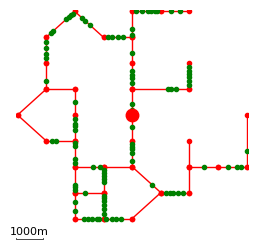

In [41]:
plotMap(MS, T=CS, w=WS, scale=True, size=3)

In [42]:
rec1 = simulation(MS, [MS], WS, CS, p=0.3, days=7, log=True)

Simulating delivery of 201 parcels over 7 days to 100 customers using 1 drivers
[ 0] 17:00:00.0 D0: Parcel 0 (for cust 13 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 1 (for cust 15 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 2 (for cust 16 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 3 (for cust 18 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 4 (for cust 19 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 5 (for cust 38 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 6 (for cust 40 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 7 (for cust 45 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 8 (for cust 45 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 9 (for cust 46 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 10 (for cust 48 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 11 (for cust 50 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 12 (for cust 52 arr at delivery centre
[ 0] 17:00:00.0 D0: Parcel 13 (for cust 53 arr at delivery centre
[ 0] 1

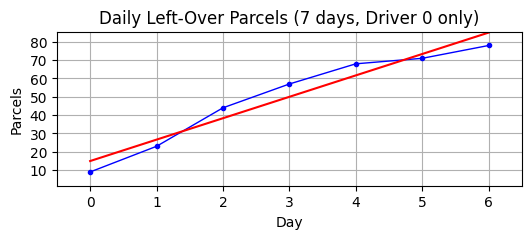

In [43]:
rec1.plotParcelsLeftOver(0)

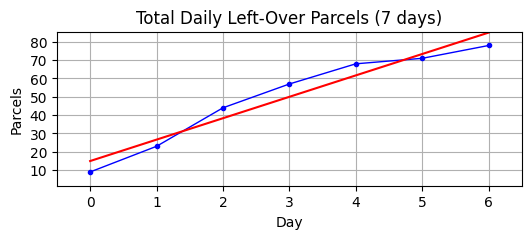

In [44]:
rec1.plotParcelsLeftOver()

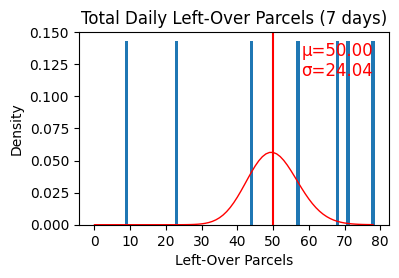

In [45]:
rec1.histParcelsLeftOver()

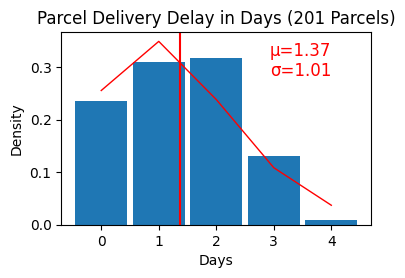

In [46]:
rec1.histParcelDeliveryDelay()

### Stable Base Case

In [47]:
import pickle
with open('testData.pickled', 'rb') as f:
    MT, CT = pickle.load(f)

In [48]:
WT = generateWarehouseLocation(MT)

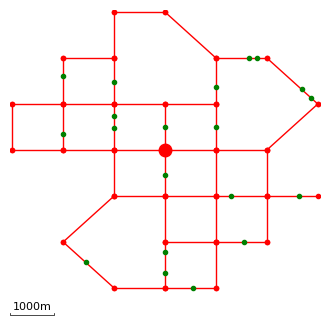

In [49]:
plotMap(MT, T=CT, w=WT, scale=True)

In [50]:
rec2 = simulation(MT, [ MT ], WT, CT, p=0.15, days=50)

Simulating delivery of 134 parcels over 50 days to 20 customers using 1 drivers
Delivery Centre Inventory at the end of last day: 1 parcels


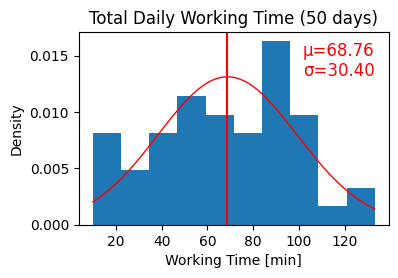

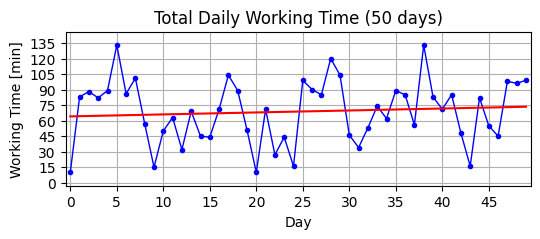

In [51]:
rec2.histWorkingTime()
rec2.plotWorkingTime()

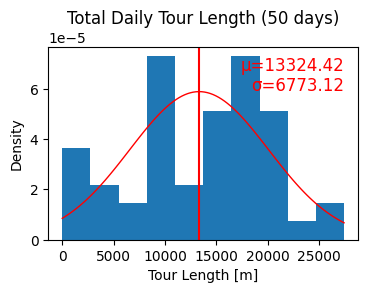

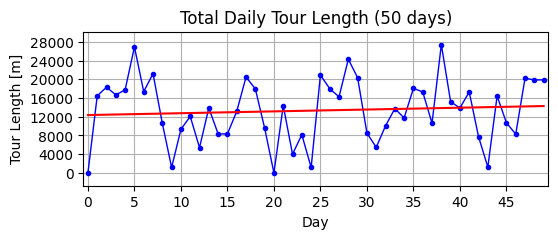

In [52]:
rec2.histTourLength()
rec2.plotTourLength()

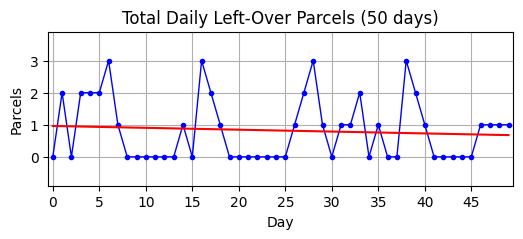

In [53]:
rec2.plotParcelsLeftOver()

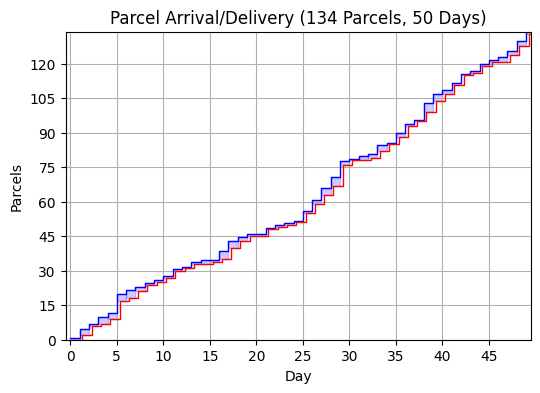

In [54]:
rec2.countPlot()

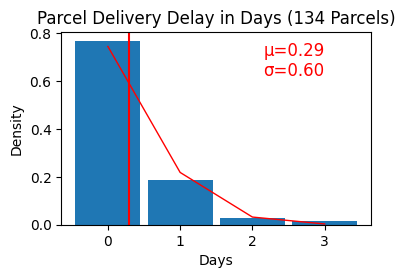

In [55]:
rec2.histParcelDeliveryDelay()

### High Demand System

In [56]:
import pickle
with open('data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [57]:
W = generateWarehouseLocation(M)

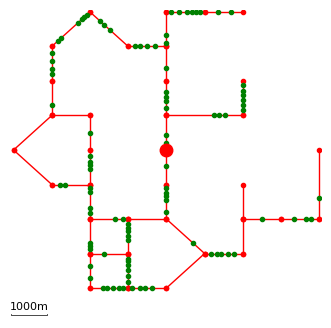

In [58]:
plotMap(M, T=C, w=W, scale=True)

In [59]:
rec3 = simulation(M, [ M ], W, C, p=0.25, days=50)

Simulating delivery of 1249 parcels over 50 days to 100 customers using 1 drivers
Delivery Centre Inventory at the end of last day: 496 parcels


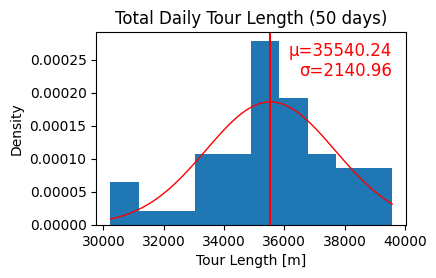

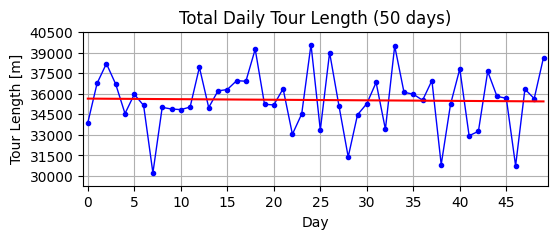

In [60]:
rec3.histTourLength()
rec3.plotTourLength()

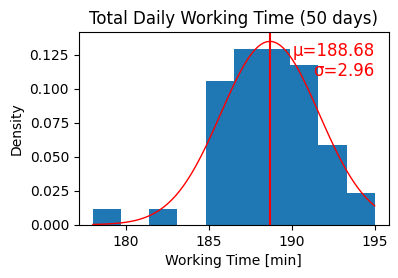

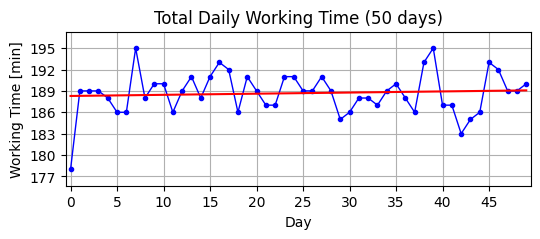

In [61]:
rec3.histWorkingTime()
rec3.plotWorkingTime()

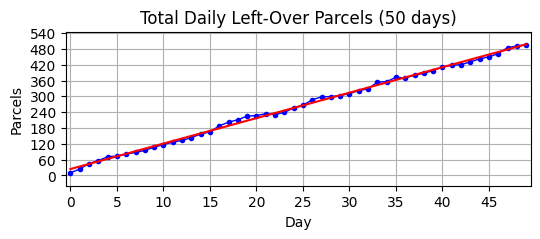

In [62]:
rec3.plotParcelsLeftOver()

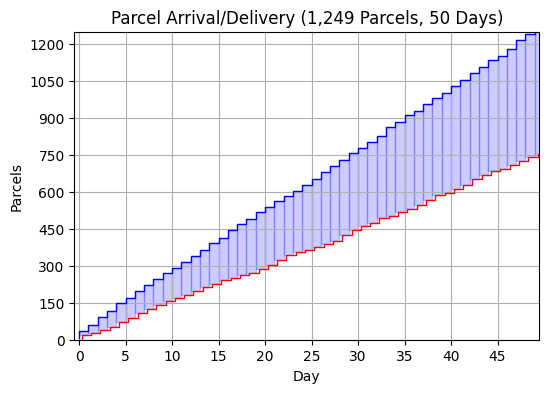

In [63]:
rec3.countPlot()

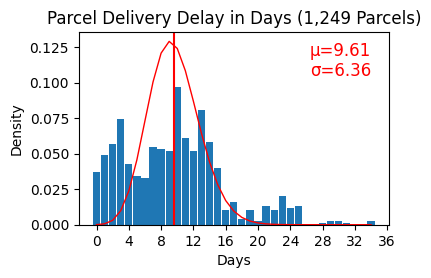

In [64]:
rec3.histParcelDeliveryDelay()